# Pergunta Problema

- Em caso de criptomoedas onde existe pode existir volatilidade nos dados, qual seria o modelo que melhor se adaptaria ?

In [6]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from prophet import Prophet
from matplotlib import pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import pandas as pd
import numpy as np
import itertools
import matplotlib.dates as mdates
import seaborn as sns
import os
!pip install ta
import ta
import datetime

In [7]:
def encontrar_pasta_mais_recente(caminho_base):
    """
    Encontra a pasta mais recente com a mascara 'data=' em um determinado caminho.

    Argumento:
        caminho_base (str): O caminho base onde as pastas estão localizadas.

    Retorno:
        str: O caminho completo para a pasta mais recente, ou None se nenhuma pasta for encontrada.
    """

    pastas_data = []
    for nome_pasta in os.listdir(caminho_base):
        if nome_pasta.startswith("date="):
            try:
                data_str = nome_pasta.split("=")[1]
                data_obj = datetime.datetime.strptime(data_str, "%Y%m%d")
                pastas_data.append((data_obj, os.path.join(caminho_base, nome_pasta)))
            # Ignora pastas com formatos de data invalidos
            except ValueError:
                pass
    # Nenhuma pasta encontrada
    if not pastas_data:
        return None

    pasta_mais_recente = max(pastas_data)[1]
    return pasta_mais_recente

In [8]:
caminho_base = "/content/drive/MyDrive/Colab Notebooks/FIAP_POS_ML/FASE3/"
pasta_mais_recente = encontrar_pasta_mais_recente(caminho_base)

if pasta_mais_recente:
    print(f"A pasta mais recente eh: {pasta_mais_recente}")
else:
    print("Nenhuma pasta encontrada com a mascara 'date='.")

A pasta mais recente eh: /content/drive/MyDrive/Colab Notebooks/FIAP_POS_ML/FASE3/date=20250312


In [9]:
df = pd.read_parquet(pasta_mais_recente)
df.head()

,date,price
0,2014-09-17,457.334015
1,2014-09-18,424.440002
2,2014-09-19,394.795990
3,2014-09-20,408.903992
4,2014-09-21,398.821014


In [10]:
# df.drop(columns=['timestamp'], inplace=True)

# 1. Preparação dos Dados

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3829 entries, 0 to 3828
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    3829 non-null   datetime64[ns]
 1   price   3829 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 60.0 KB


## 1.1 Verificação de Dados Faltantes e Duplicados

Embora o Non-Null Count do `df.info()` indique que não há valores nulos, vamos confirmar.

In [12]:
df.isnull().sum()

,0
date,0
price,0


In [13]:
def duplicates_count(df):
    """
    Verifica se existem valores duplicados no Dataframe e retorna a quantidade de duplicados.

    Argumento:
        df (pd.DataFrame): O Dataframe a ser verificado.

    Retorno:
        int: A quantidade de duplicados no Dataframe.
    """
    duplicates = df[df.duplicated(keep=False)]

    if not duplicates.empty:
        print("Valores duplicados encontrados:")
        print(duplicates)
    else:
        print("Nenhum valor duplicado encontrado.")

duplicates_count(df)

Nenhum valor duplicado encontrado.


## 1.2 Ordenação

Vamos nos certificar que os dados estejam ordenados pela coluna 'date'.

In [14]:
df_sorted = df.sort_values('date', ascending=True)

## 1.3 Frequência dos Dados

In [15]:
def validando_frequencia(df):
  """
  Valida a frequência dos dados no DataFrame.

  Argumento:
      df (pd.DataFrame): O DataFrame a ser validado.

  Retorno:
      pd.Series: Uma serie contendo a contagem de ocorrencias para cada frequencia de data.

  Exemplo:
        Se a maior parte dos valores for 1: Dados diários
        Se a maior parte dos valores for 7: Dados semanais
        Se houver uma mistura de valores, será necessário investigar mais detalhadamente.
  """
  date_diffs = df_sorted['date'].diff().dt.days
  return date_diffs.value_counts()

validando_frequencia(df_sorted)

,count
date,
1.0,3828


In [16]:
# Filtrando para encontrar onde a diferença entre as datas é 0
date_diffs = df_sorted['date'].diff().dt.days
dados_com_0_diff = df_sorted[date_diffs == 0]
print(dados_com_0_diff)

Empty DataFrame
Columns: [date, price]
Index: []


 As observações com diferenças de 0 dias podem afetar o desempenho e a precisão de um modelo de série temporal. Isso ocorre porque esses valores podem ser interpretados como dados duplicados ou fora do padrão, o que pode levar a ruídos ou padrões artificiais no modelo. Para esta análise seria interessante que os dados sigam uma sequência temporal consistente, sem duplicações ou falhas nos intervalos de tempo.

### Como as diferenças de 0 dias podem impactar:

1. **Modelos de Séries Temporais Sensíveis ao Tempo**: Modelos como ARIMA, SARIMA, LSTM, entre outros, assumem que as observações seguem um padrão temporal regular. Se houver duplicatas de data (diferença de 0 dias), o modelo pode não conseguir aprender corretamente as dependências temporais entre os pontos de dados, resultando em previsões imprecisas.

2. **Extrapolação de Padrões**: Se o modelo encontrar registros com intervalos de 0 dias, ele pode interpretar erroneamente que existe um padrão ou uma tendência de "reinício" a cada intervalo, distorcendo os resultados.

3. **Falta de Generalização**: Modelos que têm dados com registros duplicados ou com intervalo de 0 dias podem acabar "overfitting" no conjunto de dados (ajustando-se excessivamente aos dados presentes, sem capturar corretamente as tendências do mundo real).

### Como corrigir esse problema:

1. **Remover Duplicatas**: Você pode remover registros com diferenças de 0 dias para garantir que cada data seja única no seu conjunto de dados.
   
2. **Agregação de Dados**: Se o problema for causado por múltiplos registros no mesmo dia, uma estratégia comum é **agregar os dados** por dia (por exemplo, calculando a média, soma ou mediana dos valores de `price` para o mesmo dia).

3. **Interpolação de Dados Faltantes**: Se os dados faltantes (ou com diferença de 0 dias) forem um problema, uma alternativa é interpolar esses valores para preencher lacunas, embora isso deva ser feito com cuidado.


### **Agrupar os Dados para o Mesmo Dia**:

Caso você tenha múltiplos registros no mesmo dia, pode agregá-los (como média, soma, ou outro critério) para que o modelo tenha uma observação única por dia:

In [17]:
# Convertendo a coluna 'date' para datetime no formato 'YYYY-MM-DD'
df_sorted['date'] = pd.to_datetime(df_sorted['date']).dt.strftime('%Y-%m-%d')
# Agrupando os dados por data, calculando a média do preço
df_agrupado = df_sorted.groupby('date').agg({'price': 'mean'}).reset_index()

In [18]:
df_agrupado.head()

,date,price
0,2014-09-17,457.334015
1,2014-09-18,424.440002
2,2014-09-19,394.795990
3,2014-09-20,408.903992
4,2014-09-21,398.821014


In [19]:
df_agrupado.describe()

,price
count,3829.000000
mean,20982.033193
std,24208.664323
min,178.102997
25%,1421.599976
50%,9552.860352
75%,33901.527344
max,106146.265625


## 1.4 Definição do Índice

Defina a coluna 'date' como o índice do DataFrame para facilitar a análise de séries temporais, pois o Pandas entende automaticamente que esse índice é temporal, facilitando a manipulação de séries temporais.

In [20]:
df_agrupado = df_agrupado.set_index('date')
df_agrupado

,price
date,
2014-09-17,457.334015
2014-09-18,424.440002
2014-09-19,394.795990
2014-09-20,408.903992
2014-09-21,398.821014
...,...
2025-03-07,86742.671875
2025-03-08,86154.593750
2025-03-09,80601.039062


# 2. Análise Exploratória de Dados (EDA)

In [21]:
df_agrupado.describe()

,price
count,3829.000000
mean,20982.033193
std,24208.664323
min,178.102997
25%,1421.599976
50%,9552.860352
75%,33901.527344
max,106146.265625


In [22]:
df_agrupado

,price
date,
2014-09-17,457.334015
2014-09-18,424.440002
2014-09-19,394.795990
2014-09-20,408.903992
2014-09-21,398.821014
...,...
2025-03-07,86742.671875
2025-03-08,86154.593750
2025-03-09,80601.039062


## Visualização da Série Temporal

vamos Plotar a série temporal para identificar tendências, sazonalidades e padrões. Vamos também usar gráficos de linha para visualizar a evolução do preço ao longo do tempo.

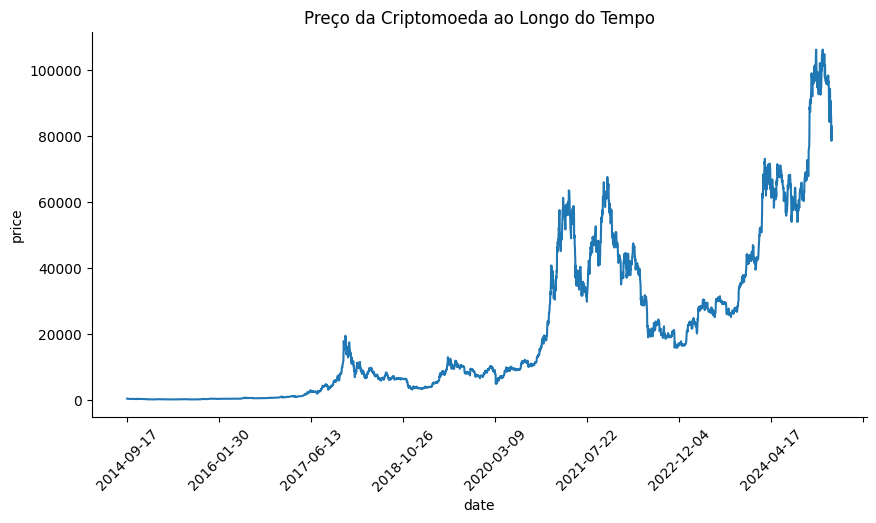

In [23]:
df_agrupado['price'].plot(kind='line', figsize=(10, 5), title='price')
plt.gca().spines[['top', 'right']].set_visible(False)
plt.xticks(rotation=45)
plt.xlabel('date')
plt.ylabel('price')
plt.title('Preço da Criptomoeda ao Longo do Tempo')
plt.show()

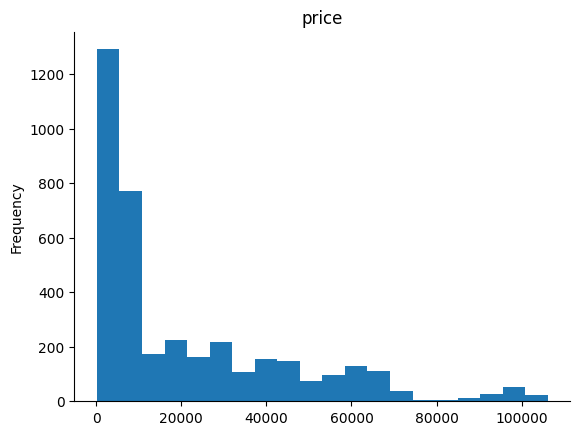

In [24]:
df_agrupado['price'].plot(kind='hist', bins=20, title='price')
plt.gca().spines[['top', 'right',]].set_visible(False)

## Análise de Sazonalidade

Realizamos a decomposição de séries temporais para identificar componentes de tendência, sazonalidade e resíduos.

A sazonalidade refere-se a padrões repetitivos e previsíveis que ocorrem em uma série temporal em intervalos regulares. Esses padrões podem ser diários, semanais, mensais, anuais ou de qualquer outra periodicidade.

Em outras palavras, a sazonalidade é quando os dados exibem um comportamento cíclico que se repete ao longo do tempo.

**Sabemos que nossos dados são diários, então não encontraremos sazonalidades semanais ou anuais.**

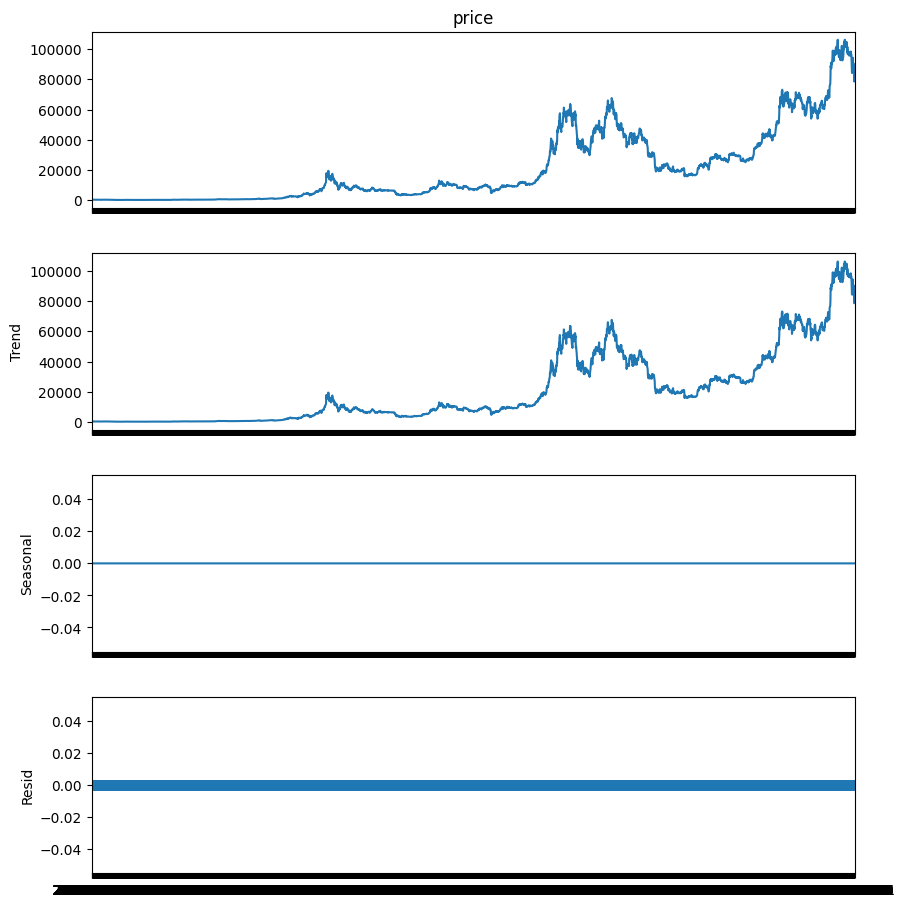

In [41]:
decomposition = seasonal_decompose(df_agrupado['price'], model='additive', period = 1) # use period = 7 para sazonalidade semanal.
fig = decomposition.plot()
fig.set_size_inches(10, 10)
plt.show()

A volatilidade (desvio padrão dos retornos) para entender a variação dos preços.

A volatilidade mede o grau de variação ou flutuação dos preços de um ativo financeiro em um determinado período.

Em termos simples, a volatilidade indica o quão "instável" é o preço de um ativo.

No mercado financeiro, a volatilidade é frequentemente medida pelo desvio padrão dos retornos de um ativo.


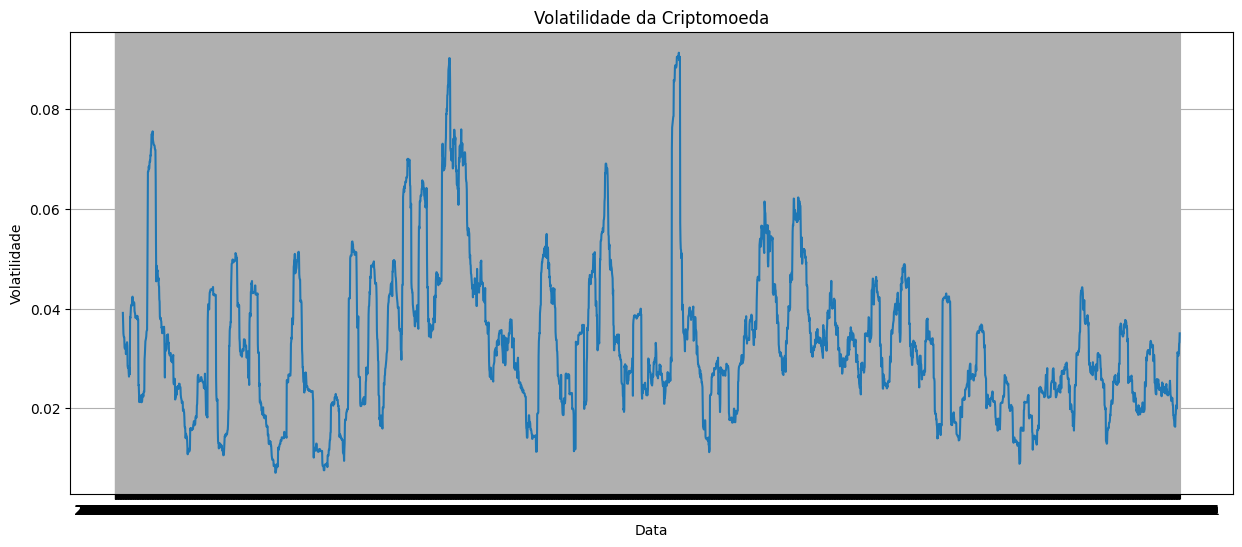

In [26]:
df_analise = pd.DataFrame(df_agrupado['price'])

df_analise['returns'] = df_agrupado['price'].pct_change()
df_analise['volatility'] = df_analise['returns'].rolling(window=30).std() # volatilidade calculada com janela de 30 dias.
plt.figure(figsize=(15, 6))
plt.plot(df_analise['volatility'])
plt.title('Volatilidade da Criptomoeda')
plt.xlabel('Data')
plt.ylabel('Volatilidade')
plt.grid(True)
plt.show()

Podemos verificar uma Volatilidade dos Considerável dos Dados, aqui temos uma ideia de que o modelo de LSMT pode ter um desempenho melhor que o ARIMA.

In [42]:
df_analise['lag_1'] = df_agrupado['price'].shift(1)
df_analise['rolling_mean_3'] = df_agrupado['price'].rolling(window=3).mean()
df_analise['rolling_mean_7'] = df_agrupado['price'].rolling(window=7).mean()
df_analise['rolling_mean_30'] = df_agrupado['price'].rolling(window=30).mean()
df_analise['rolling_mean_45'] = df_agrupado['price'].rolling(window=45).mean()
df_analise['rolling_mean_60'] = df_agrupado['price'].rolling(window=60).mean()
df_analise['rolling_mean_75'] = df_agrupado['price'].rolling(window=75).mean()
df_analise['rolling_mean_90'] = df_agrupado['price'].rolling(window=90).mean()
df_analise['rolling_mean_120'] = df_agrupado['price'].rolling(window=120).mean()
df_analise['rolling_mean_365'] = df_agrupado['price'].rolling(window=365).mean()
df_analise['rolling_mean_2x365'] = df_agrupado['price'].rolling(window=365*2).mean()
df_analise['rolling_mean_3x365'] = df_agrupado['price'].rolling(window=365*3).mean()

In [43]:
df_analise.tail()

,price,returns,volatility,lag_1,rolling_mean_3,rolling_mean_7,rolling_mean_30,rolling_mean_45,rolling_mean_60,rolling_mean_75,...,MA_7,MA_30,RSI,MACD,MACD_signal,MACD_hist,rolling_mean_120,rolling_mean_365,rolling_mean_2x365,rolling_mean_3x365
date,,,,,,,,,,,,,,,,,,,,,
2025-03-07,86742.671875,-0.035782,0.031087,89961.726562,89109.320312,88699.441964,93159.946354,96069.545313,96679.515104,96616.036250,...,88699.441964,93159.946354,41.582334,-2514.231925,-2563.439769,49.207843,96124.408464,74799.974187,54252.655445,44399.220853
2025-03-08,86154.593750,-0.006780,0.031089,86742.671875,87619.664062,88716.967634,92811.989583,95680.690278,96500.046615,96502.280938,...,88716.967634,92811.989583,40.806863,-2578.222584,-2566.396332,-11.826253,96204.484440,74848.890625,54342.780886,44439.560276
2025-03-09,80601.039062,-0.064460,0.033022,86154.593750,84499.434896,86767.351562,92281.054688,95161.598437,96259.338542,96261.280208,...,86767.351562,92281.054688,34.301259,-3041.994870,-2661.516039,-380.478830,96236.335872,74882.047217,54425.539509,44477.152585
2025-03-10,78532.000000,-0.025670,0.033211,80601.039062,81762.544271,85691.112723,91682.706250,94577.432118,96026.804557,95984.384271,...,85691.112723,91682.706250,32.239112,-3535.734165,-2836.359664,-699.374501,96220.150977,74908.108069,54504.854016,44513.442107
2025-03-11,82862.210938,0.055139,0.035046,78532.000000,80665.083333,85068.257812,91228.110156,94091.822396,95829.483854,95811.940208,...,85068.257812,91228.110156,40.324991,-3536.843747,-2976.456481,-560.387266,96171.490365,74937.528082,54588.002320,44553.586581


## Interpretação dos Indicadores:

### Médias Móveis (MA):

O cruzamento das médias móveis de curto e longo prazo pode indicar sinais de compra ou venda.
Quando a MA de curto prazo cruza acima da MA de longo prazo, pode ser um sinal de compra.
Quando a MA de curto prazo cruza abaixo da MA de longo prazo, pode ser um sinal de venda.

### Índice de Força Relativa (RSI):

Valores acima de 70 indicam condições de sobrecompra, sugerindo uma possível reversão de baixa.
Valores abaixo de 30 indicam condições de sobrevenda, sugerindo uma possível reversão de alta.

### Convergência/Divergência da Média Móvel (MACD):

O cruzamento da linha MACD com a linha de sinal pode indicar sinais de compra ou venda.
Quando a linha MACD cruza acima da linha de sinal, pode ser um sinal de compra.
Quando a linha MACD cruza abaixo da linha de sinal, pode ser um sinal de venda.
O histograma MACD indica a diferença entre a linha MACD e a linha de sinal, fornecendo informações adicionais sobre a força da tendência.

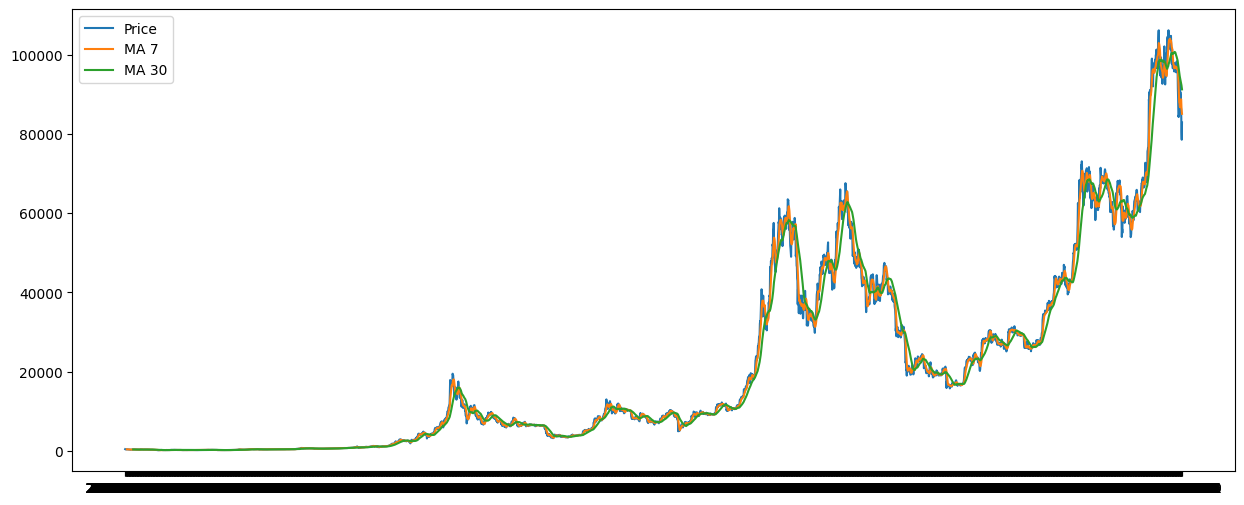

In [29]:
# Calculate Simple Moving Average (SMA)
df_analise['MA_7'] = ta.trend.sma_indicator(df_analise['price'], window=7)
df_analise['MA_30'] = ta.trend.sma_indicator(df_analise['price'], window=30)

# Calculate RSI
df_analise['RSI'] = ta.momentum.rsi(df_analise['price'], window=14)

# Calculate MACD
macd = ta.trend.MACD(df_analise['price'])
df_analise['MACD'] = macd.macd()
df_analise['MACD_signal'] = macd.macd_signal()
df_analise['MACD_hist'] = macd.macd_diff()

plt.figure(figsize=(15,6))
plt.plot(df_analise['price'], label = "Price")
plt.plot(df_analise['MA_7'], label = "MA 7")
plt.plot(df_analise['MA_30'], label = "MA 30")
plt.legend()
plt.show()

In [44]:
df_analise.tail(14)

,price,returns,volatility,lag_1,rolling_mean_3,rolling_mean_7,rolling_mean_30,rolling_mean_45,rolling_mean_60,rolling_mean_75,...,MA_7,MA_30,RSI,MACD,MACD_signal,MACD_hist,rolling_mean_120,rolling_mean_365,rolling_mean_2x365,rolling_mean_3x365
date,,,,,,,,,,,,,,,,,,,,,
2025-02-26,84347.023438,-0.049463,0.020559,88736.171875,88167.122396,93116.075893,97041.288281,98724.240625,97974.059245,98155.859479,...,93116.075893,97041.288281,24.684970,-2379.672253,-1329.525670,-1050.146583,94864.485677,74215.129249,53449.662559,44013.565998
2025-02-27,84704.226562,0.004235,0.020644,84347.023438,85929.140625,91168.974330,96487.013281,98506.189583,97826.959245,97933.609583,...,91168.974330,96487.013281,25.863520,-2884.708918,-1640.562319,-1244.146598,94967.524740,74275.949625,53533.987042,44051.475580
2025-02-28,84373.007812,-0.003910,0.019903,84704.226562,84474.752604,89490.040179,95842.673177,98235.944271,97689.122526,97667.933750,...,89490.040179,95842.673177,25.465592,-3273.940747,-1967.238005,-1306.702742,95085.506576,74339.441749,53617.173970,44088.022037
2025-03-01,86031.914062,0.019662,0.020259,84373.007812,85036.382812,87983.491071,95219.226823,97914.331424,97565.834375,97401.296354,...,87983.491071,95219.226823,31.176986,-3409.250192,-2255.640442,-1153.609749,95223.418620,74404.075396,53702.867733,44126.476646
2025-03-02,94248.351562,0.095505,0.027265,86031.914062,88217.757812,87694.123884,94947.337760,97791.919097,97562.977604,97242.733021,...,87694.123884,94947.337760,51.145193,-2820.967703,-2368.705894,-452.261809,95431.410937,74492.345270,53801.341256,44173.779443
2025-03-03,86065.671875,-0.086820,0.031242,94248.351562,88781.979167,86929.481027,94460.996615,97383.110937,97382.624219,97056.388125,...,86929.481027,94460.996615,39.007201,-2980.664216,-2491.097559,-489.566657,95575.782227,74555.080340,53888.618410,44216.636125
2025-03-04,87222.195312,0.013438,0.031052,86065.671875,89178.739583,86713.198661,94112.103906,97001.202604,97201.203646,96919.471354,...,86713.198661,94112.103906,41.133639,-2979.556603,-2588.789368,-390.767236,95737.537956,74606.838645,53977.367289,44260.308827
2025-03-05,90623.562500,0.038997,0.031096,87222.195312,87970.476562,87609.847098,93752.708594,96768.623785,97074.325911,96824.373125,...,87609.847098,93752.708594,46.987426,-2673.399620,-2605.711418,-67.688202,95914.737956,74680.324572,54070.783460,44307.983328
2025-03-06,89961.726562,-0.007303,0.030533,90623.562500,89269.161458,88360.918527,93489.038802,96500.736285,96935.105339,96727.533125,...,88360.918527,93489.038802,46.028299,-2455.862974,-2575.741729,119.878755,96034.093359,74745.680522,54163.580661,44355.380303


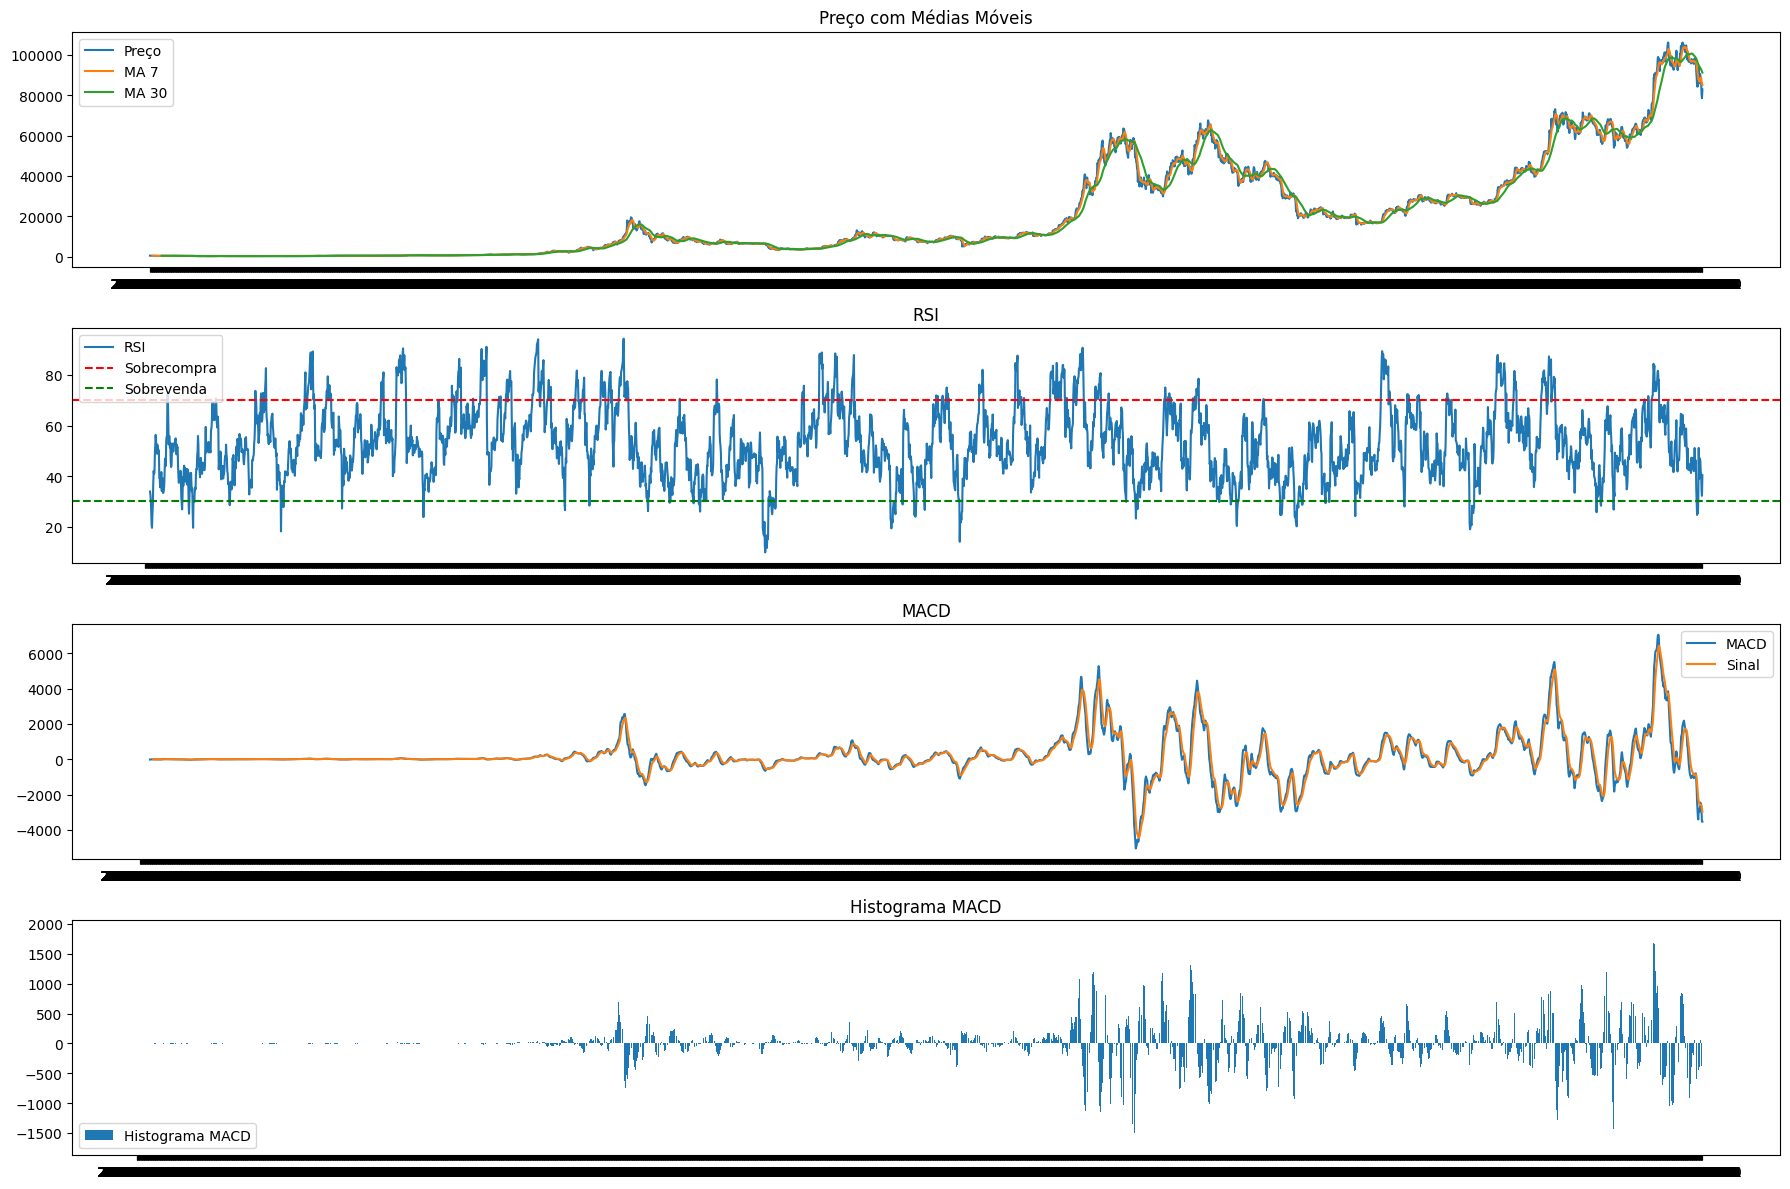

In [31]:
plt.figure(figsize=(18, 12))

# Preço e Médias Móveis
plt.subplot(4, 1, 1)
plt.plot(df_analise['price'], label='Preço')
plt.plot(df_analise['MA_7'], label='MA 7')
plt.plot(df_analise['MA_30'], label='MA 30')
plt.title('Preço com Médias Móveis')
plt.legend()

# RSI
plt.subplot(4, 1, 2)
plt.plot(df_analise['RSI'], label='RSI')
plt.title('RSI')
plt.axhline(70, color='red', linestyle='--', label='Sobrecompra')
plt.axhline(30, color='green', linestyle='--', label='Sobrevenda')
plt.legend()

# MACD
plt.subplot(4, 1, 3)
plt.plot(df_analise['MACD'], label='MACD')
plt.plot(df_analise['MACD_signal'], label='Sinal')
plt.title('MACD')
plt.legend()

# Histograma MACD
plt.subplot(4, 1, 4)
plt.bar(df_analise.index, df_analise['MACD_hist'], label='Histograma MACD')
plt.title('Histograma MACD')
plt.legend()

plt.tight_layout()
plt.show()

# Modelos de Séries Temporais

ARIMA (AutoRegressive Integrated Moving Average): Adequado para séries temporais estacionárias.

LSTM (Long Short-Term Memory): Uma rede neural recorrente poderosa para capturar dependências temporais complexas.

Prophet: Modelo desenvolvido pelo facebook, para previsão de séries temporais com forte sazonalidade.

In [32]:
df_agrupado_2 = df_agrupado.copy()

In [33]:
# Preparação dos dados para LSTM
def criar_dataset_lstm(dataset, tempo_passado=1):
  """
  Prepara os dados para LSTM.
  """
  dataX, dataY = [], []
  for i in range(len(dataset) - tempo_passado - 1):
      a = dataset[i:(i + tempo_passado), 0]
      dataX.append(a)
      dataY.append(dataset[i + tempo_passado, 0])
  return np.array(dataX), np.array(dataY)

def avaliar_modelos(df, coluna_preco='price', tamanho_teste=0.2):
    """
    Avalia o desempenho dos modelos ARIMA, LSTM e Prophet em uma série temporal.

    Args:
        df (pd.DataFrame): DataFrame com a série temporal.
        coluna_preco (str): Nome da coluna com os preços.
        tamanho_teste (float): Proporção dos dados para o conjunto de teste.

    Returns:
        pd.DataFrame: DataFrame com os resultados dos modelos.
    """

    # Divisão dos dados em treino e teste
    tamanho_treino = int(len(df) * (1 - tamanho_teste))
    treino, teste = df[coluna_preco][:tamanho_treino], df[coluna_preco][tamanho_treino:]

    resultados = {}

    # 2. Modelo ARIMA
    try:
        modelo_arima = ARIMA(treino, order=(5, 1, 0))  # Ajuste os parâmetros (p, d, q) conforme necessário
        modelo_arima_fit = modelo_arima.fit()
        previsoes_arima = modelo_arima_fit.forecast(steps=len(teste))
        rmse_arima = np.sqrt(mean_squared_error(teste, previsoes_arima))
        resultados['ARIMA'] = rmse_arima
    except Exception as e:
        print(f"Erro no ARIMA: {e}")

    # 3. Modelo LSTM
    try:
        dados_treino_lstm = treino.values.reshape(-1, 1)
        dados_teste_lstm = teste.values.reshape(-1, 1)

        tempo_passado = 60  # Ajuste o tempo passado conforme necessário
        X_treino, y_treino = criar_dataset_lstm(dados_treino_lstm, tempo_passado)
        X_teste, y_teste = criar_dataset_lstm(dados_teste_lstm, tempo_passado)

        X_treino = np.reshape(X_treino, (X_treino.shape[0], 1, X_treino.shape[1]))
        X_teste = np.reshape(X_teste, (X_teste.shape[0], 1, X_teste.shape[1]))

        # Modelo LSTM
        modelo_lstm = Sequential()
        modelo_lstm.add(LSTM(50, return_sequences=True, input_shape=(1, tempo_passado)))
        modelo_lstm.add(LSTM(50))
        modelo_lstm.add(Dense(1))
        modelo_lstm.compile(loss='mean_squared_error', optimizer='adam')
        modelo_lstm.fit(X_treino, y_treino, epochs=10, batch_size=32, verbose=0)

        previsoes_lstm = modelo_lstm.predict(X_teste)
        rmse_lstm = np.sqrt(mean_squared_error(y_teste, previsoes_lstm))
        resultados['LSTM'] = rmse_lstm
    except Exception as e:
        print(f"Erro no LSTM: {e}")

    # 4. Modelo Prophet
    try:
        df_prophet = df.reset_index()
        df_prophet = df_prophet[['date', coluna_preco]].rename(columns={'date': 'ds', coluna_preco: 'y'})

        modelo_prophet = Prophet()
        modelo_prophet.fit(df_prophet[:tamanho_treino])
        futuro = modelo_prophet.make_future_dataframe(periods=len(teste))
        previsoes_prophet = modelo_prophet.predict(futuro)
        rmse_prophet = np.sqrt(mean_squared_error(teste, previsoes_prophet['yhat'][tamanho_treino:]))
        resultados['Prophet'] = rmse_prophet
    except Exception as e:
        print(f"Erro no Prophet: {e}")

    return pd.Series(resultados)

In [34]:
resultados_modelos = avaliar_modelos(df_agrupado)
print("\n\nRMSE (Root Mean Squared Error) para cada modelo.\nO modelo com o menor RMSE terá o melhor desempenho.\n\n")
print(resultados_modelos)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2q_z381e/0e9ik93d.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2q_z381e/nf09970z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67789', 'data', 'file=/tmp/tmp2q_z381e/0e9ik93d.json', 'init=/tmp/tmp2q_z381e/nf09970z.json', 'output', 'file=/tmp/tmp2q_z381e/prophet_modelhj6_g1hg/prophet_model-20250312201712.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:17:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:17:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing




RMSE (Root Mean Squared Error) para cada modelo.
O modelo com o menor RMSE terá o melhor desempenho.


ARIMA      38557.658679
LSTM       60408.567761
Prophet    71535.341528
dtype: float64


## 3. Interpretação dos Primeiros Resultados:

O modelo com o menor RMSE terá o melhor desempenho.

### Considerações:

1. **Ajuste de Parâmetros**: Os parâmetros dos modelos (ordem do ARIMA, tempo passado do LSTM, etc.) podem ser ajustados para melhorar o desempenho.
2. **Validação Cruzada**: Poderíamos usar Validação Cruzada, porém como nosso Dataset é pequeno teremos problemas com valores NaN quando o Dataset receber o Split, por isso iremos utilziar uma divisão simples em 80/20.
3. **LSTM**:
   - O LSTM é um modelo mais complexo e pode exigir mais dados e poder computacional.
   - Além do mais, LSTMs são redes neurais e funcionam melhor com dados normalizados entre 0 e 1 ou -1 e 1.
   - O MinMaxScaler ajuda a estabilizar o treinamento e pode acelerar a convergência.
4. **ARIMA**:
   - O ARIMA geralmente não precisa de normalização, pois é baseado em diferenças e tendências.
   - Se os valores forem muito grandes ou dispersos, a normalização pode ajudar a evitar problemas numéricos.
5. **Prophet**:
  - O Prophet é baseado em decomposição de séries temporais e, em geral, não precisa de normalização. No entanto, pode ser útil normalizar caso os valores sejam muito grandes ou pequenos.
  - O Prophet é especialmente eficaz para séries temporais com forte sazonalidade.

In [35]:
def evaluate_arima(df):
    p_values = range(0, 5)
    d_values = range(0, 5)
    q_values = range(0, 5)
    best_rmse, best_order = float('inf'), None

    train_size = int(len(df) * 0.8)
    train, test = df.iloc[:train_size], df.iloc[train_size:]

    for p, d, q in itertools.product(p_values, d_values, q_values):
        try:
            model = ARIMA(train, order=(p, d, q)).fit()
            predictions = model.forecast(len(test))
            rmse = np.sqrt(mean_squared_error(test, predictions))
            mae = mean_absolute_error(test, predictions)

            print(f'ARIMA({p},{d},{q}) - RMSE: {rmse:.2f}, MAE: {mae:.2f}')

            if rmse < best_rmse:
                best_rmse, best_order = rmse, (p, d, q)
        except:
            continue

    return best_order, best_rmse

def evaluate_lstm(df, epochs=20, batch_size=1):
    # Normalização
    scaler = MinMaxScaler()
    df_scaled = scaler.fit_transform(df)

    # Divisão em treino e teste
    train_size = int(len(df_scaled) * 0.8)
    train, test = df_scaled[:train_size], df_scaled[train_size:]

    # Preparação dos dados para o modelo LSTM
    X_train, y_train = train[:-1], train[1:]
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))

    # Definição e treinamento do modelo LSTM
    model = Sequential([
        LSTM(50, activation='relu', input_shape=(X_train.shape[1], 1)),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)

    # Preparação dos dados de teste para as previsões
    X_test = test[:-1].reshape((test.shape[0] - 1, test.shape[1], 1))
    predictions = model.predict(X_test)

    # Desnormalização das previsões
    predictions = scaler.inverse_transform(predictions)  # Desnormaliza as previsões

    # Cálculo dos erros
    rmse = np.sqrt(mean_squared_error(df.iloc[train_size + 1:], predictions))
    mae = mean_absolute_error(df.iloc[train_size + 1:], predictions)

    print(f'LSTM - RMSE: {rmse:.2f}, MAE: {mae:.2f}')

    return rmse

def evaluate_prophet(df):
    df_prophet = df.reset_index().rename(columns={'date': 'ds', 'price': 'y'})

    # Divisão de treino e teste
    train_size = int(len(df_prophet) * 0.8)
    train, test = df_prophet.iloc[:train_size], df_prophet.iloc[train_size:]

    # Definindo os parâmetros de sazonalidade para testar
    yearly_seasonality = [True, False]  # Testando sazonalidade anual (True/False)
    weekly_seasonality = [True, False]  # Testando sazonalidade semanal (True/False)
    daily_seasonality = [True, False]   # Testando sazonalidade diária (True/False)
    seasonality_prior_scales = [10, 1, 0.1]  # Testando diferentes valores para prior_scale

    best_rmse = float('inf')
    best_params = None

    # Testando diferentes combinações de sazonalidade
    for yearly in yearly_seasonality:
        for weekly in weekly_seasonality:
            for daily in daily_seasonality:
                for prior_scale in seasonality_prior_scales:
                    model = Prophet(
                        yearly_seasonality=yearly,
                        weekly_seasonality=weekly,
                        daily_seasonality=daily,
                        seasonality_prior_scale=prior_scale
                    )

                    model.fit(train)
                    future = model.make_future_dataframe(periods=len(test))
                    forecast = model.predict(future)
                    predictions = forecast['yhat'].iloc[-len(test):].values

                    rmse = np.sqrt(mean_squared_error(test['y'], predictions))
                    mae = mean_absolute_error(test['y'], predictions)

                    print(f'Prophet with Yearly: {yearly}, Weekly: {weekly}, Daily: {daily}, Prior Scale: {prior_scale} - RMSE: {rmse:.2f}, MAE: {mae:.2f}')

                    if rmse < best_rmse:
                        best_rmse = rmse
                        best_params = (yearly, weekly, daily, prior_scale)

    print(f'Best Parameters: {best_params} with RMSE: {best_rmse:.2f}')

    return best_rmse



In [36]:
import warnings
warnings.filterwarnings("ignore")

In [37]:
evaluate_arima(df_agrupado_2)

ARIMA(0,0,0) - RMSE: 47041.78, MAE: 40145.48
ARIMA(0,0,1) - RMSE: 47040.69, MAE: 40138.21
ARIMA(0,0,2) - RMSE: 47040.28, MAE: 40135.50
ARIMA(0,0,3) - RMSE: 47039.39, MAE: 40127.82
ARIMA(0,0,4) - RMSE: 47038.03, MAE: 40119.36
ARIMA(0,1,0) - RMSE: 38564.15, MAE: 29835.41
ARIMA(0,1,1) - RMSE: 38561.95, MAE: 29832.72
ARIMA(0,1,2) - RMSE: 38562.57, MAE: 29833.48
ARIMA(0,1,3) - RMSE: 38567.98, MAE: 29840.08
ARIMA(0,1,4) - RMSE: 38563.14, MAE: 29834.22
ARIMA(0,2,0) - RMSE: 89785.36, MAE: 74826.96
ARIMA(0,2,1) - RMSE: 35703.28, MAE: 27266.60
ARIMA(0,2,2) - RMSE: 35464.33, MAE: 27050.56
ARIMA(0,2,3) - RMSE: 35358.86, MAE: 26955.73
ARIMA(0,2,4) - RMSE: 35365.35, MAE: 26963.48
ARIMA(0,3,0) - RMSE: 12583112.87, MAE: 9394250.05
ARIMA(0,3,1) - RMSE: 98729.00, MAE: 81626.01
ARIMA(0,3,2) - RMSE: 103381.50, MAE: 81260.43
ARIMA(0,3,3) - RMSE: 37039.29, MAE: 28320.01
ARIMA(0,3,4) - RMSE: 10831.67, MAE: 7732.13
ARIMA(0,4,0) - RMSE: 9256662435.37, MAE: 6129876928.67
ARIMA(0,4,1) - RMSE: 13645650.70, MAE: 1

((0, 3, 4), 10831.666049672283)

In [38]:
evaluate_lstm(df_agrupado_2)

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
LSTM - RMSE: 2690.68, MAE: 2018.71


2690.6786318696627

In [39]:
evaluate_prophet(df_agrupado_2)

DEBUG:cmdstanpy:input tempfile: /tmp/tmp2q_z381e/eu75g3qv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2q_z381e/fgslfzw9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30055', 'data', 'file=/tmp/tmp2q_z381e/eu75g3qv.json', 'init=/tmp/tmp2q_z381e/fgslfzw9.json', 'output', 'file=/tmp/tmp2q_z381e/prophet_modelgjxs3txz/prophet_model-20250312202328.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:23:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:23:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2q_z381e/yq57216l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2q_z381e/7bdfupry.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Prophet with Yearly: True, Weekly: True, Daily: True, Prior Scale: 10 - RMSE: 71707.80, MAE: 61153.86


20:23:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2q_z381e/rm7svo9l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2q_z381e/nuc9pj25.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85136', 'data', 'file=/tmp/tmp2q_z381e/rm7svo9l.json', 'init=/tmp/tmp2q_z381e/nuc9pj25.json', 'output', 'file=/tmp/tmp2q_z381e/prophet_model5f9as7xz/prophet_model-20250312202331.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:23:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Prophet with Yearly: True, Weekly: True, Daily: True, Prior Scale: 1 - RMSE: 71397.21, MAE: 60852.98


20:23:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2q_z381e/ll94vgeb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2q_z381e/9i79yxkp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19332', 'data', 'file=/tmp/tmp2q_z381e/ll94vgeb.json', 'init=/tmp/tmp2q_z381e/9i79yxkp.json', 'output', 'file=/tmp/tmp2q_z381e/prophet_modelwanfri0v/prophet_model-20250312202332.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:23:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Prophet with Yearly: True, Weekly: True, Daily: True, Prior Scale: 0.1 - RMSE: 71444.29, MAE: 60899.13


20:23:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2q_z381e/a2mnp9m9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2q_z381e/1zhdrev6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47254', 'data', 'file=/tmp/tmp2q_z381e/a2mnp9m9.json', 'init=/tmp/tmp2q_z381e/1zhdrev6.json', 'output', 'file=/tmp/tmp2q_z381e/prophet_modeln2vfmht7/prophet_model-20250312202333.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:23:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Prophet with Yearly: True, Weekly: True, Daily: False, Prior Scale: 10 - RMSE: 71535.34, MAE: 60987.76


20:23:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2q_z381e/i6z_898x.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2q_z381e/th749nl_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5566', 'data', 'file=/tmp/tmp2q_z381e/i6z_898x.json', 'init=/tmp/tmp2q_z381e/th749nl_.json', 'output', 'file=/tmp/tmp2q_z381e/prophet_model4oxqmx_6/prophet_model-20250312202334.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:23:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Prophet with Yearly: True, Weekly: True, Daily: False, Prior Scale: 1 - RMSE: 71019.78, MAE: 60481.51


20:23:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2q_z381e/nr51o618.json


Prophet with Yearly: True, Weekly: True, Daily: False, Prior Scale: 0.1 - RMSE: 71312.74, MAE: 60770.05


DEBUG:cmdstanpy:input tempfile: /tmp/tmp2q_z381e/dg2mns26.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62478', 'data', 'file=/tmp/tmp2q_z381e/nr51o618.json', 'init=/tmp/tmp2q_z381e/dg2mns26.json', 'output', 'file=/tmp/tmp2q_z381e/prophet_modeln923nm97/prophet_model-20250312202335.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:23:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:23:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2q_z381e/5jrlmhpt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2q_z381e/q6xrk26s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.b

Prophet with Yearly: True, Weekly: False, Daily: True, Prior Scale: 10 - RMSE: 71769.75, MAE: 61215.50


20:23:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2q_z381e/v3oyhcla.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2q_z381e/k3otonse.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43669', 'data', 'file=/tmp/tmp2q_z381e/v3oyhcla.json', 'init=/tmp/tmp2q_z381e/k3otonse.json', 'output', 'file=/tmp/tmp2q_z381e/prophet_modelh3rwcgrq/prophet_model-20250312202338.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:23:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Prophet with Yearly: True, Weekly: False, Daily: True, Prior Scale: 1 - RMSE: 71427.04, MAE: 60880.92


20:23:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2q_z381e/zypuuee3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2q_z381e/l0r3busz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57865', 'data', 'file=/tmp/tmp2q_z381e/zypuuee3.json', 'init=/tmp/tmp2q_z381e/l0r3busz.json', 'output', 'file=/tmp/tmp2q_z381e/prophet_modelvhvh12wt/prophet_model-20250312202339.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:23:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Prophet with Yearly: True, Weekly: False, Daily: True, Prior Scale: 0.1 - RMSE: 71432.67, MAE: 60886.50


20:23:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2q_z381e/hfwkw296.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2q_z381e/0x0dg9gw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6162', 'data', 'file=/tmp/tmp2q_z381e/hfwkw296.json', 'init=/tmp/tmp2q_z381e/0x0dg9gw.json', 'output', 'file=/tmp/tmp2q_z381e/prophet_model5hfyeaer/prophet_model-20250312202340.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:23:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Prophet with Yearly: True, Weekly: False, Daily: False, Prior Scale: 10 - RMSE: 71390.65, MAE: 60844.40


20:23:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2q_z381e/e3xk_4c5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2q_z381e/5h1zq37t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51223', 'data', 'file=/tmp/tmp2q_z381e/e3xk_4c5.json', 'init=/tmp/tmp2q_z381e/5h1zq37t.json', 'output', 'file=/tmp/tmp2q_z381e/prophet_modelru4mlhx8/prophet_model-20250312202341.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:23:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Prophet with Yearly: True, Weekly: False, Daily: False, Prior Scale: 1 - RMSE: 71433.43, MAE: 60888.42


20:23:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2q_z381e/oodx_365.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2q_z381e/xf4s0b_a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36462', 'data', 'file=/tmp/tmp2q_z381e/oodx_365.json', 'init=/tmp/tmp2q_z381e/xf4s0b_a.json', 'output', 'file=/tmp/tmp2q_z381e/prophet_modely4bl3dwh/prophet_model-20250312202342.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:23:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Prophet with Yearly: True, Weekly: False, Daily: False, Prior Scale: 0.1 - RMSE: 71446.85, MAE: 60900.76


20:23:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2q_z381e/o8ibjxrv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2q_z381e/wmw_pp1r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46339', 'data', 'file=/tmp/tmp2q_z381e/o8ibjxrv.json', 'init=/tmp/tmp2q_z381e/wmw_pp1r.json', 'output', 'file=/tmp/tmp2q_z381e/prophet_modelfvrgofyk/prophet_model-20250312202343.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:23:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Prophet with Yearly: False, Weekly: True, Daily: True, Prior Scale: 10 - RMSE: 70769.67, MAE: 60158.24


20:23:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2q_z381e/zf3b3xzz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2q_z381e/a_dfy6hw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5770', 'data', 'file=/tmp/tmp2q_z381e/zf3b3xzz.json', 'init=/tmp/tmp2q_z381e/a_dfy6hw.json', 'output', 'file=/tmp/tmp2q_z381e/prophet_model4nc1lzot/prophet_model-20250312202345.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:23:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Prophet with Yearly: False, Weekly: True, Daily: True, Prior Scale: 1 - RMSE: 70897.87, MAE: 60286.02


20:23:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2q_z381e/ctqay4ec.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2q_z381e/_bm35ms_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23290', 'data', 'file=/tmp/tmp2q_z381e/ctqay4ec.json', 'init=/tmp/tmp2q_z381e/_bm35ms_.json', 'output', 'file=/tmp/tmp2q_z381e/prophet_modelu1jwvlab/prophet_model-20250312202346.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:23:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Prophet with Yearly: False, Weekly: True, Daily: True, Prior Scale: 0.1 - RMSE: 70714.36, MAE: 60106.28


20:23:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2q_z381e/v1j_dt5e.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2q_z381e/vrojx29t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79148', 'data', 'file=/tmp/tmp2q_z381e/v1j_dt5e.json', 'init=/tmp/tmp2q_z381e/vrojx29t.json', 'output', 'file=/tmp/tmp2q_z381e/prophet_modelsiiynh6a/prophet_model-20250312202347.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:23:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Prophet with Yearly: False, Weekly: True, Daily: False, Prior Scale: 10 - RMSE: 71065.47, MAE: 60447.81


20:23:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2q_z381e/py0twfld.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2q_z381e/bpk5t6ji.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57584', 'data', 'file=/tmp/tmp2q_z381e/py0twfld.json', 'init=/tmp/tmp2q_z381e/bpk5t6ji.json', 'output', 'file=/tmp/tmp2q_z381e/prophet_modelhb3a7ne1/prophet_model-20250312202348.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:23:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Prophet with Yearly: False, Weekly: True, Daily: False, Prior Scale: 1 - RMSE: 71211.94, MAE: 60591.70


20:23:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2q_z381e/o4z1a4lw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2q_z381e/5ya8bpl8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43054', 'data', 'file=/tmp/tmp2q_z381e/o4z1a4lw.json', 'init=/tmp/tmp2q_z381e/5ya8bpl8.json', 'output', 'file=/tmp/tmp2q_z381e/prophet_model68r7m2qn/prophet_model-20250312202349.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:23:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Prophet with Yearly: False, Weekly: True, Daily: False, Prior Scale: 0.1 - RMSE: 71053.25, MAE: 60434.92


20:23:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2q_z381e/vjz6ibq3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2q_z381e/v300d0d5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71413', 'data', 'file=/tmp/tmp2q_z381e/vjz6ibq3.json', 'init=/tmp/tmp2q_z381e/v300d0d5.json', 'output', 'file=/tmp/tmp2q_z381e/prophet_modelj59p9jji/prophet_model-20250312202350.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:23:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Prophet with Yearly: False, Weekly: False, Daily: True, Prior Scale: 10 - RMSE: 70615.79, MAE: 60011.16


20:23:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2q_z381e/x47wrrzb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2q_z381e/0g1pmqby.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74339', 'data', 'file=/tmp/tmp2q_z381e/x47wrrzb.json', 'init=/tmp/tmp2q_z381e/0g1pmqby.json', 'output', 'file=/tmp/tmp2q_z381e/prophet_model3mr_37la/prophet_model-20250312202351.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:23:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Prophet with Yearly: False, Weekly: False, Daily: True, Prior Scale: 1 - RMSE: 71009.20, MAE: 60393.38


20:23:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2q_z381e/9z9smztj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2q_z381e/4bcvirgc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71969', 'data', 'file=/tmp/tmp2q_z381e/9z9smztj.json', 'init=/tmp/tmp2q_z381e/4bcvirgc.json', 'output', 'file=/tmp/tmp2q_z381e/prophet_model2mhx3pkw/prophet_model-20250312202352.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:23:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Prophet with Yearly: False, Weekly: False, Daily: True, Prior Scale: 0.1 - RMSE: 70716.72, MAE: 60110.63


20:23:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2q_z381e/vuxddfgw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2q_z381e/qskeuidz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55011', 'data', 'file=/tmp/tmp2q_z381e/vuxddfgw.json', 'init=/tmp/tmp2q_z381e/qskeuidz.json', 'output', 'file=/tmp/tmp2q_z381e/prophet_modelzsdy6019/prophet_model-20250312202353.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:23:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Prophet with Yearly: False, Weekly: False, Daily: False, Prior Scale: 10 - RMSE: 70915.67, MAE: 60300.82


20:23:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2q_z381e/jmb6y_r0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2q_z381e/x_pbsamz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67882', 'data', 'file=/tmp/tmp2q_z381e/jmb6y_r0.json', 'init=/tmp/tmp2q_z381e/x_pbsamz.json', 'output', 'file=/tmp/tmp2q_z381e/prophet_modeld4jafo9w/prophet_model-20250312202353.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:23:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Prophet with Yearly: False, Weekly: False, Daily: False, Prior Scale: 1 - RMSE: 70915.67, MAE: 60300.82


20:23:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Prophet with Yearly: False, Weekly: False, Daily: False, Prior Scale: 0.1 - RMSE: 70915.67, MAE: 60300.82
Best Parameters: (False, False, True, 10) with RMSE: 70615.79


70615.79063936048

ARIMA(0, 3, 4) - RMSE: 10831.67

LSTM - RMSE: 2690.68, MAE: 2018.71

Prophet with Daily: True, Prior Scale: 10 - RMSE: 70615.79, MAE: 60011.16

## Análise:

### LSTM Desempenho Superior:

O modelo LSTM apresentou o melhor desempenho, com os menores valores de RMSE e MAE. Isso indica que o LSTM foi capaz de capturar melhor os padrões e a complexidade dos dados de séries temporais.

### ARIMA Desempenho Moderado:
O modelo ARIMA teve um desempenho moderado, com valores de RMSE e MAE maiores do que o LSTM, mas significativamente menores do que o Prophet. Isso sugere que o ARIMA conseguiu capturar algumas das tendências, mas pode não ter sido tão eficaz em lidar com a volatilidade ou padrões não lineares.

### Prophet Desempenho Ruim:
O modelo Prophet teve o pior desempenho, com valores de RMSE e MAE muito altos. Isso indica que o Prophet pode não ser adequado para este conjunto de dados específico ou que os parâmetros podem precisar de ajustes significativos. Também é possível que a alta volatilidade dos dados de criptomoedas tenha prejudicado o desempenho do modelo.

# Considerações:

## Ajuste de Hiperparâmetros:
Embora os modelos tenham sido testados, ajustes adicionais nos hiperparâmetros podem melhorar ainda mais o desempenho.

## Volatilidade:
O mercado de criptomoedas é altamente volátil, o que pode dificultar a previsão precisa. Modelos que conseguem capturar a volatilidade, como o LSTM, tendem a ter um desempenho melhor.

## Tamanho dos Dados:
O tamanho do conjunto de dados pode afetar o desempenho dos modelos.

## Quantidade:
Quantidade pequena de Dados.